In [ ]:

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re

from math import exp
from numpy import sign

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk import PorterStemmer

from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [ ]:
DEPRES_NROWS = 4644  # number of rows to read from DEPRESSIVE_TWEETS_CSV
RANDOM_NROWS = 5356 # number of rows to read from RANDOM_TWEETS_CSV
MAX_SEQUENCE_LENGTH = 54 # Max tweet size
MAX_NB_WORDS = 10000
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.6
TEST_SPLIT = 0.2
LEARNING_RATE = 0.1
EPOCHS= 10

In [ ]:
sdf=pd.read_csv('/content/gdrive/My Drive/Capstone/dataset/sfinal_dataset.csv')

In [ ]:
sdf=sdf.drop(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'created_at', 'tweet',	'language',	'clean_tweet',	'clean_tweet_exp',	'cleanest_tweet','user_id'], axis = 1 )
sdf = sdf.sample(frac = 1)
sdf['lem_tweet']=sdf['lem_tweet'].map(str)
tweets=sdf['lem_tweet']



In [ ]:
depressive_tweets_arr=sdf.loc[sdf['vader_sentiment_label'] == 0.0]
depressive_tweets_arr=depressive_tweets_arr.drop(['vader_score','vader_sentiment_label'],axis = 1)
depressive_tweets_arr.head(5)
depressive_tweets_arr=list(depressive_tweets_arr['lem_tweet'])
X_d=depressive_tweets_arr
depressive_tweets_arr[0]
len(depressive_tweets_arr)


4644

In [ ]:
random_tweets_arr=sdf.loc[sdf['vader_sentiment_label'] == 1.0]
random_tweets_arr=random_tweets_arr.drop(['vader_score','vader_sentiment_label'],axis = 1)
random_tweets_arr.head(5)
random_tweets_arr=list(random_tweets_arr['lem_tweet'])
random_tweets_arr[0]
X_r=random_tweets_arr
len(random_tweets_arr)

5356

In [ ]:
word2vec = KeyedVectors.load_word2vec_format('/content/gdrive/MyDrive/Capstone/dataset/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_d + X_r)


In [ ]:
sequences_d = tokenizer.texts_to_sequences(X_d)
sequences_r = tokenizer.texts_to_sequences(X_r)
print(sequences_d)

[[2, 874, 8], [518, 798, 761, 2207, 463, 84, 28, 329, 51, 2, 2208], [166, 26, 2], [494, 4123, 6884, 1724, 875, 4, 384, 1, 16, 4124, 294, 477, 134], [108, 421, 61, 4125, 75, 616, 1198, 369, 6885, 6886, 6887, 218, 1293, 1, 4126, 12, 157, 1, 3, 152, 307, 34, 17, 1725, 85, 566, 4127, 6888], [1726, 9, 48, 128, 46, 6889, 831, 1947, 1107, 1, 288, 48, 19, 2209, 589, 6890, 139, 14, 1, 119, 4, 6891], [6892, 1948, 6893, 6894, 6895], [7, 2], [469, 6896, 190], [1, 94, 3, 1294, 6897, 347, 670, 147, 52, 272, 91, 6898, 4128], [3183, 6899, 370, 1108, 6900, 617, 4], [6901, 1, 5, 23, 762, 153, 9, 2210], [1727, 17, 1949, 3184, 357, 180, 2573], [323, 4129, 4, 28], [1, 6902, 4, 1950, 500, 1951], [1952, 228, 2211], [2574, 422, 832, 1728, 6903, 973, 1199, 1953, 554, 833], [1109, 205, 48, 162, 14], [358, 63, 283, 16, 1, 60, 2575, 4130, 303], [2, 671, 423, 1200, 393, 2576, 2577, 519], [208, 30, 4131, 974, 28, 1201], [106, 2, 25, 79, 92, 2, 31, 2], [136, 6904, 2212, 452], [30, 294, 67, 534, 1202, 6905], [92, 264

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 15330 unique tokens


In [ ]:

data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
data_r = pad_sequences(sequences_r, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data_d tensor:', data_d.shape)
print('Shape of data_r tensor:', data_r.shape)


Shape of data_d tensor: (4644, 54)
Shape of data_r tensor: (5356, 54)


In [ ]:
nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
print(word_index)
for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < MAX_NB_WORDS:
        embedding_matrix[idx] = word2vec.word_vec(word)
embedding_matrix[1]

{'i': 1, 'lonely': 2, 'feel': 3, 'anxiety': 4, 'get': 5, 'like': 6, 'im': 7, 'face': 8, 'go': 9, 'good': 10, 'day': 11, 'love': 12, 'make': 13, 'time': 14, 'know': 15, 'think': 16, 'one': 17, 'want': 18, 'see': 19, 'well': 20, 'people': 21, 'would': 22, 'work': 23, 'the': 24, 'need': 25, 'amp': 26, 'really': 27, 'today': 28, 'say': 29, 'new': 30, 'come': 31, 'happy': 32, 'cry': 33, 'back': 34, 'you': 35, 'take': 36, 'not': 37, 'look': 38, 'heart': 39, 'thing': 40, 'thanks': 41, 'lol': 42, 'night': 43, 'much': 44, 'help': 45, 'morning': 46, 'even': 47, 'twitter': 48, 'still': 49, 'hope': 50, 'na': 51, 'and': 52, 'my': 53, 'dont': 54, 'can': 55, 'great': 56, 'way': 57, 'us': 58, 'give': 59, 'watch': 60, 'bad': 61, 'friend': 62, 'sleep': 63, 'always': 64, 'tear': 65, 'but': 66, 'life': 67, '2': 68, 'try': 69, 'right': 70, 'smile': 71, 'yes': 72, 'use': 73, 'it': 74, 'best': 75, 'thank': 76, 'year': 77, 'u': 78, 'show': 79, 'talk': 80, 'never': 81, 'someone': 82, 'please': 83, 'start': 84,

array([-2.25585938e-01, -1.95312500e-02,  9.08203125e-02,  2.37304688e-01,
       -2.92968750e-02,  9.32617188e-02, -5.88378906e-02, -4.10156250e-02,
        5.22460938e-02,  2.00195312e-02, -3.44238281e-02, -2.91015625e-01,
       -2.61718750e-01, -1.90429688e-01,  3.85742188e-02,  8.30078125e-03,
        3.14941406e-02,  7.47070312e-02,  1.14746094e-01,  1.24511719e-02,
       -2.11914062e-01,  1.28906250e-01,  2.55859375e-01,  1.08886719e-01,
       -7.03125000e-02,  1.60156250e-01, -4.00390625e-01, -1.16699219e-01,
       -3.22265625e-02, -6.73828125e-02,  1.55273438e-01,  1.25000000e-01,
       -6.22558594e-02,  3.56445312e-02, -1.79687500e-01,  1.58203125e-01,
       -2.53906250e-01,  1.74804688e-01, -1.18164062e-01, -2.19726562e-03,
        1.49536133e-02, -5.71289062e-02,  2.39257812e-01,  1.36718750e-01,
        1.47460938e-01,  7.08007812e-02,  1.72851562e-01, -2.38281250e-01,
       -5.71289062e-02, -1.04492188e-01,  2.23388672e-02,  8.74023438e-02,
        1.43554688e-01,  

In [ ]:
# Assigning labels to the depressive tweets and random tweets data
labels_d = np.array([1] * DEPRES_NROWS)
labels_r = np.array([0] * RANDOM_NROWS)

# Splitting the arrays into test (60%), validation (20%), and train data (20%)
perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT)):]

perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[:int(len(data_r)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_r)*(TRAIN_SPLIT)):int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT)):]

# Combine depressive tweets and random tweets arrays
data_train = np.concatenate((data_d[idx_train_d], data_r[idx_train_r]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_r[idx_train_r]))
data_test = np.concatenate((data_d[idx_test_d], data_r[idx_test_r]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_r[idx_test_r]))
data_val = np.concatenate((data_d[idx_val_d], data_r[idx_val_r]))
labels_val = np.concatenate((labels_d[idx_val_d], labels_r[idx_val_r]))

# Shuffling
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]



In [ ]:

model = Sequential()
# Embedded layer
model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False))
# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
# LSTM Layer
model.add(LSTM(300))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
# another Convolutional Layer
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.2))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 54, 300)           3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 54, 32)            28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 27, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 300)               399600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=EPOCHS, batch_size=40, shuffle=True, \
        callbacks=[early_stop])

Epoch 1/10
150/150 [==============================] - 25s 144ms/step - loss: 0.5378 - acc: 0.7385 - val_loss: 0.4366 - val_acc: 0.8166
Epoch 2/10
150/150 [==============================] - 22s 145ms/step - loss: 0.3812 - acc: 0.8428 - val_loss: 0.3966 - val_acc: 0.8226
Epoch 3/10
150/150 [==============================] - 22s 146ms/step - loss: 0.3068 - acc: 0.8715 - val_loss: 0.3827 - val_acc: 0.8411
Epoch 4/10
150/150 [==============================] - 22s 146ms/step - loss: 0.2573 - acc: 0.8990 - val_loss: 0.3555 - val_acc: 0.8501
Epoch 5/10
150/150 [==============================] - 22s 149ms/step - loss: 0.1962 - acc: 0.9240 - val_loss: 0.3794 - val_acc: 0.8531
Epoch 6/10
150/150 [==============================] - 22s 148ms/step - loss: 0.1538 - acc: 0.9433 - val_loss: 0.3998 - val_acc: 0.8616
Epoch 7/10
150/150 [==============================] - 22s 147ms/step - loss: 0.1278 - acc: 0.9528 - val_loss: 0.4228 - val_acc: 0.8611
Epoch 8/10
150/150 [==============================] - 2

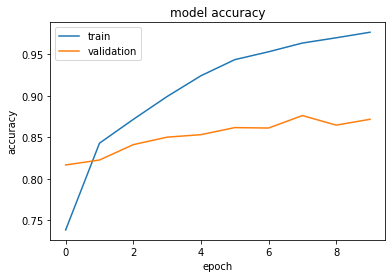

In [ ]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

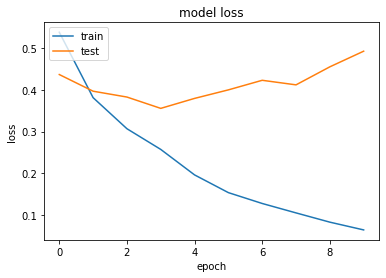

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))
type(data_test)

Accuracy: 87.70%


numpy.ndarray

In [ ]:
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1071
           1       0.89      0.84      0.86       929

    accuracy                           0.88      2000
   macro avg       0.88      0.87      0.88      2000
weighted avg       0.88      0.88      0.88      2000



In [ ]:
model.save('/content/gdrive/MyDrive/Capstone/model/model1')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Capstone/model/model1/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Capstone/model/model1/assets


In [ ]:
test=pd.read_csv('/content/gdrive/MyDrive/Capstone/dataset/created_depression.csv')
test.head()
a=test['Tweet'].astype('string')
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(a)
sequences_d = tokenizer.texts_to_sequences(a)
word_index = tokenizer.word_index
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
print(nb_words)
print(word_index)
print(MAX_NB_WORDS)
for (word, idx) in word_index.items():
  if word in word2vec.vocab and idx < MAX_NB_WORDS:
    embedding_matrix[idx-1] = word2vec.word_vec(word)
test = data_d
labels_pred=model.predict(test)
print(labels_pred)





64
{'i': 1, 'happy': 2, 'my': 3, 'sad': 4, 'today': 5, 'want': 6, 'to': 7, 'life': 8, 'was': 9, 'day': 10, 'and': 11, "i'm": 12, 'very': 13, 'a': 14, 'as': 15, 'well': 16, 'anti': 17, 'pills': 18, 'really': 19, 'kill': 20, 'suicide': 21, 'love': 22, 'an': 23, 'amazing': 24, 'had': 25, 'nice': 26, 'burger': 27, 'am': 28, 'got': 29, 'promotion': 30, 'boss': 31, 'with': 32, 'me': 33, 'met': 34, 'grandkids': 35, 'need': 36, 'depressant': 37, 'just': 38, 'wanna': 39, 'get': 40, 'them': 41, 'drugs': 42, 'so': 43, 'been': 44, 'crying': 45, 'the': 46, 'whole': 47, 'sucks': 48, 'myself': 49, 'never': 50, 'anymore': 51, 'im': 52, 'always': 53, 'commit': 54, 'dont': 55, 'continue': 56, 'living': 57, 'depression': 58, 'angry': 59, 'anxiety': 60, 'cry': 61, 'depressents': 62, 'eat': 63, 'fries': 64}
10000
[[7.01057361e-05]
 [9.78223681e-02]
 [4.18090167e-07]
 [6.69687986e-04]
 [7.78297186e-02]
 [6.93290349e-05]
 [1.09156966e-01]
 [5.31201243e-01]
 [9.99778032e-01]]
